<a href="https://colab.research.google.com/github/Akash-collaab/akashwebproject2/blob/master/sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

This code essentially performs time series forecasting using a linear regression model on monthly sales data. It involves data preprocessing, model training, prediction, evaluation, and visualization

Import necessary libraries

In [2]:
import pandas as pd # data cleaning, data preprocessing, data exploration, and basic statistical analysis.
import numpy as np # for numerical computing
import matplotlib.pyplot as plt #for plotting library
from xgboost import XGBRegressor # XGBRegressor is a class provided by the XGBoost library for building regression models. #predictive model by combining multiple weak models
from sklearn.ensemble import RandomForestRegressor # is a class provided by the scikit-learn library for building regression models using a technique called Random Forest.
from sklearn.linear_model import LinearRegression # class/the relationship between a dependent variable and one or more independent variables.
from sklearn.preprocessing import MinMaxScaler # to preprocess your data before feeding it to machine learning algorithms
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score #average absolute difference between the predicted values and the true values.represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
from tensorflow.keras.models import Sequential # class keras api/integrated into TensorFlow/allowsuscreate a linear stack of layers for building neural network models
from tensorflow.keras.layers import Dense, LSTM # c/./ used for defining layers in neural network models.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # callback classes././stops training when a monitored metric has stopped improving&saves the model's weights at certain intervals during training.






Read the data from a CSV file named "train.csv" into a DataFrame and display the first 10 rows:

In [3]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-01-02,1,1,11.0
2,2013-01-03,1,1,14.0
3,2013-01-04,1,1,13.0
4,2013-01-05,1,1,10.0
5,2013-01-06,1,1,12.0
6,2013-01-07,1,1,10.0
7,2013-01-08,1,1,9.0
8,2013-01-09,1,1,12.0
9,2013-01-10,1,1,9.0


Display information about the DataFrame to check data types and missing values:

checking for null values in the dataset

In [4]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227618 entries, 0 to 227617
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    227618 non-null  object 
 1   store   227618 non-null  int64  
 2   item    227618 non-null  int64  
 3   sales   227617 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.9+ MB


Since, we will deal with overall sales of the items in all of the stores. We'll need to disregard the columns representing the store id & item id. Dropping store and item column

In [5]:
store_sales = store_sales.drop(['store','item'],axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227618 entries, 0 to 227617
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    227618 non-null  object 
 1   sales   227617 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.5+ MB


In [6]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227618 entries, 0 to 227617
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    227618 non-null  object 
 1   sales   227617 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.5+ MB


converting date from object datatype to dateTime datatype

Convert the 'date' column to datetime format:


In [7]:

store_sales['date']=pd.to_datetime(store_sales['date'])


In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227618 entries, 0 to 227617
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    227618 non-null  datetime64[ns]
 1   sales   227617 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 MB


Drop unnecessary columns 'store' and 'item':x

\we want to train the model to predict the sales in the next month, so we are converting the date to a Month period, and then sum the number of itmes in each month

In [9]:
 store_sales['date'] = store_sales['date'].dt.to_period("M")
 monthly_sales = store_sales.groupby('date').sum().reset_index()

converting the resulting date column to timestamp datatype

In [10]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,114596.0
1,2013-02-01,116257.0
2,2013-03-01,155972.0
3,2013-04-01,172027.0
4,2013-05-01,192094.0
5,2013-06-01,201325.0
6,2013-07-01,215546.0
7,2013-08-01,193231.0
8,2013-09-01,173583.0
9,2013-10-01,166130.0


Plot monthly sales data:


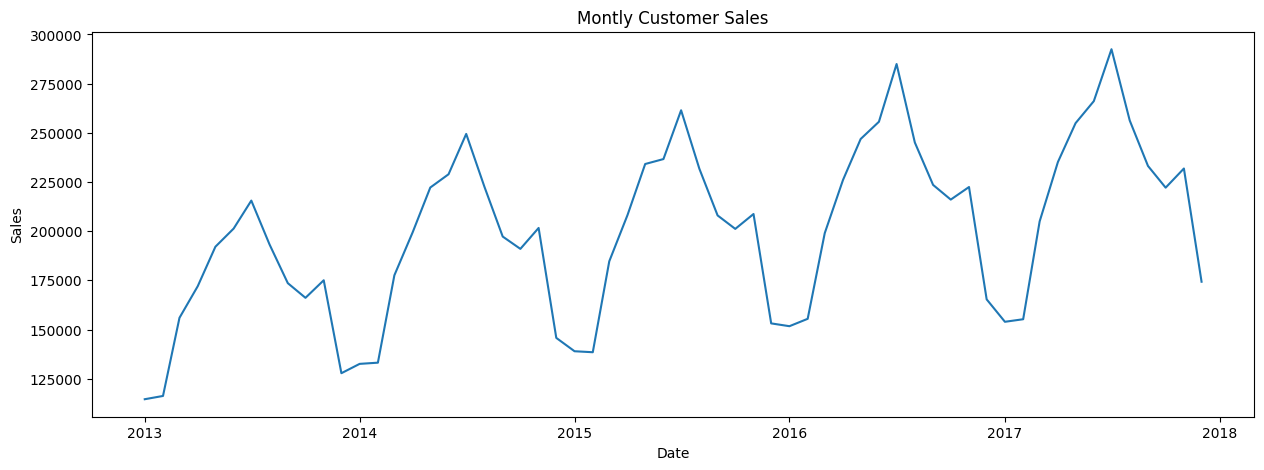

In [11]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Montly Customer Sales")
plt.show()

Calculate monthly sales difference and plot the difference:

calls the difference on the sales columns to make the sales data stationery

In [12]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales =  monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,116257.0,1661.0
2,2013-03-01,155972.0,39715.0
3,2013-04-01,172027.0,16055.0
4,2013-05-01,192094.0,20067.0
5,2013-06-01,201325.0,9231.0
6,2013-07-01,215546.0,14221.0
7,2013-08-01,193231.0,-22315.0
8,2013-09-01,173583.0,-19648.0
9,2013-10-01,166130.0,-7453.0
10,2013-11-01,175052.0,8922.0


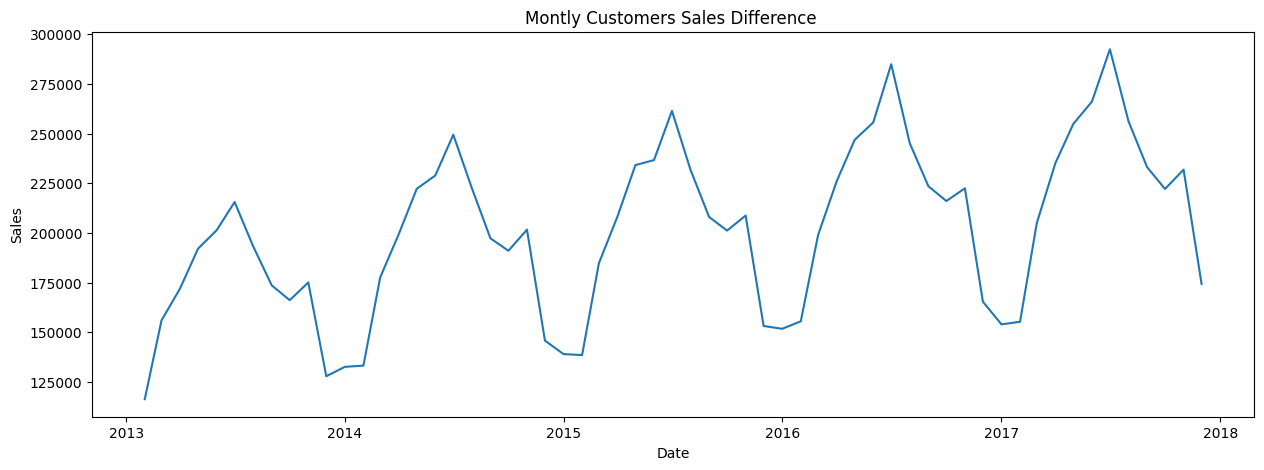

In [13]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Montly Customers Sales Difference ")
plt.show()

Prepare supervised learning data by creating lag features:

We need to train our models to predict the sales in the next months, we are doing that by seeing the sales in the previous month. so we need to prepare a supervised data, set to feed into the ML model.

previous 12months data will predict the next 1year sales, why? To train stationary data fo ML model

Dropping of sales and date

In [14]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

preparing supervised data

In [15]:
for i in range(1,13):
  col_name = 'month_'+ str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data =  supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0,39715.0,1661.0
1,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0,39715.0
2,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0,16055.0
3,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0,20067.0
4,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0,9231.0
5,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0,14221.0
6,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0,-22315.0
7,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0,-19648.0
8,-6263.0,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0,-7453.0
9,10634.0,-6263.0,-25256.0,-26903.0,20504.0,6738.0,22793.0,21810.0,44414.0,608.0,4744.0,-47234.0,8922.0


Split the data into train and test sets:

spliting the data into train and test data

In [16]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


Scale the data using MinMaxScaler:


In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Prepare input and output data for training and testing:

first col output and second col rep input

In [18]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shap:", x_train.shape)
print("Y_train Shap:", x_train.shape)
print("X_test Shap:", x_test.shape)
print("Y_test Shap:", x_test.shape)



X_train Shap: (35, 12)
Y_train Shap: (35, 12)
X_test Shap: (12, 12)
Y_test Shap: (12, 12)


Create a DataFrame for predictions:

EVerything till there is data prediction.

Mkae prediction data frame to merge the predicted sales prices of all trained Algorithm.

In [19]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [20]:
act_sales =  monthly_sales['sales'][-13:].to_list()
print(act_sales)

[165349.0, 153953.0, 155247.0, 204981.0, 235144.0, 254901.0, 266091.0, 292477.0, 256249.0, 233154.0, 222120.0, 231851.0, 174306.0]


Fit a Linear Regression model and make predictions:


Linear Regression basically tries to find A Linear relationship with a set of input variables and output variables. So weigth attched to the i/p variable are updated during the training phase, so that the predicted o/p aligns well with the designed o/p. And to train Linear regression we can simply call it using the scikit-package and we will pass the raining data. we use the predict func of linear regression to the predicted o/p.

To create the linear regression model, and predicted o/p.

In [21]:
lr_model= LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)

Inverse transform the scaled predictions:

In [22]:
lr_pre = lr_pre.reshape(-1,1)
# THis is a set matrix - contains the input features of the test data, and also the predicted o/p
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

Combine the predictions with actual sales:

In [23]:
result_list =[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

Calculate evaluation metrics for the Linear Regression model:\
Print evaluation metrics:

In [24]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])) #MSE measures the average squared difference between the predicted values and the true values
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]) #MAE measures the average absolute difference between the predicted values and the true values.
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]) #R-squared is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)



Linear Regression MSE:  4388.093318706285
Linear Regression MAE:  3328.454649056536
Linear Regression R2:  0.9889547698786051


Plot actual vs predicted sales:

visalization of the prediction against eh actual sales

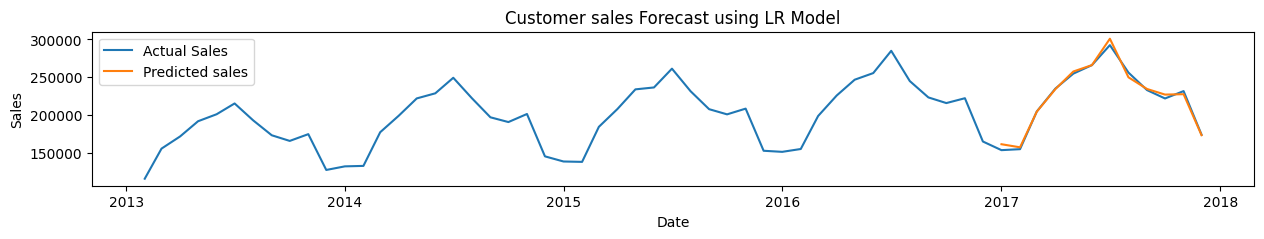

In [25]:
plt.figure(figsize=(15,2))
# For Actual Sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])

# The Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()



1. **pandas**: pandas is a powerful data manipulation and analysis library for Python. It provides data structures like DataFrame and Series, which allow you to easily manipulate and analyze structured data. pandas is widely used for tasks such as data cleaning, data preprocessing, data exploration, and basic statistical analysis.

2. **numpy**: numpy is a fundamental package for numerical computing in Python. It provides support for multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently. numpy is extensively used in scientific computing, data analysis, and machine learning tasks due to its efficiency and versatility.

3. **matplotlib**: matplotlib is a plotting library for Python that enables you to create a wide variety of static, interactive, and animated visualizations. It provides a MATLAB-like interface and supports various types of plots, including line plots, scatter plots, bar plots, histograms, and more. matplotlib is commonly used for data visualization and presentation of analytical results.

4. **xgboost**: XGBoost (eXtreme Gradient Boosting) is an efficient and scalable implementation of gradient boosting decision trees. It is a popular machine learning library known for its high performance and accuracy in supervised learning tasks, such as regression and classification. XGBoost is widely used in competitions and real-world applications due to its ability to handle large datasets and produce highly accurate predictions.

5. **scikit-learn**: scikit-learn is a versatile machine learning library for Python that provides simple and efficient tools for data mining and data analysis. It includes various algorithms for classification, regression, clustering, dimensionality reduction, and model selection. scikit-learn is widely used for building and evaluating machine learning models, as well as for data preprocessing and model selection.

6. **tensorflow.keras**: TensorFlow is an open-source machine learning framework developed by Google. Keras is a high-level neural networks API that runs on top of TensorFlow, providing a user-friendly interface for building and training deep learning models. The `tensorflow.keras` module allows you to build neural networks using Keras within the TensorFlow ecosystem. It supports various types of neural network architectures, including fully connected networks, convolutional neural networks (CNNs), recurrent neural networks (RNNs), and more.
